**Задача 1**

Реализовать Adam, AdamW и обучить сверточную нейросеть на MNIST. Сравнить графики обучения для SGD, Adam и AdamW.

**Импорты библиотек и загрузка датасета**

In [20]:
import numpy as np
import pandas as pd
import torch
import torchvision
import matplotlib
import torch.nn.functional as F

In [21]:
image_transform = torchvision.transforms.ToTensor()
train_dataset = torchvision.datasets.MNIST(root = './data' , train = True , transform = image_transform,download = True)
test_dataset = torchvision.datasets.MNIST(root = './data' , train = False , transform = image_transform,download = True)

In [22]:
image,lable  = train_dataset[0]
print(image.shape)

torch.Size([1, 28, 28])


**Тут добавь визуализации**

**Архитектура сверточной сети**

![image.png](attachment:85dfe687-92d5-468f-ba21-069393fe1561.png)

In [23]:
import torch.nn as nn

In [24]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 1 cверточный слой
        self.Conv1 = nn.Conv2d(1,6,5)
        # 1 слой пулинга
        self.Pool1 = nn.AvgPool2d(2,2)
        # 2 сверточный слой
        self.Conv2 = nn.Conv2d(6,16,5)
        # 2 слой пуллинга
        self.Pool2  = nn.AvgPool2d(2,2)

        # Полносвязные слои:
        #fc1
        self.fc1 = nn.Linear(4*4*16,120)
        #fc2
        self.fc2 = nn.Linear(120,84)
        #fc3
        self.fc3 = nn.Linear(84,10)

    def forward(self,x):
        x = F.relu(self.Conv1(x))
        x = self.Pool1(x)
        x = F.relu(self.Conv2(x))
        x = self.Pool2(x)
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [25]:
from torch.utils.data import DataLoader

In [26]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [27]:
def train_model(model,train_loader,test_loader,optimizer,num_epochs):
    train_loss = []
    test_accuracy = []

    metric = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch_ind , (data ,  target) in enumerate(train_loader):
            optimizer.zero_grad()

            output = model(data)

            current_loss = metric(output,target)

            current_loss.backward()

            optimizer.step()

            total_loss += current_loss.item()

        model.eval()  # режим оценки
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in test_loader:
                output = model(data)
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()


        avg_loss = total_loss / len(train_loader)
        accuracy = 100 * correct / total

        train_loss.append(avg_loss)
        test_accuracy.append(accuracy)

        print(f'Epoch {epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.2f}%')

    return train_loss, test_accuracy

<b> Тестируем модель с SGD <b>

In [28]:
model = LeNet()

# 2. Создаем оптимизатор SGD
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# 3. Запускаем обучение на 5 эпох
print("Начинаем обучение с SGD...")
train_losses_sgd, test_accuracies_sgd = train_model(
    model, train_loader, test_loader, optimizer, num_epochs=5
)

# 4. Смотрим на результаты
print("SGD рез:")
print(f"Финальная точность: {test_accuracies_sgd[-1]:.2f}%")

Начинаем обучение с SGD...
Epoch 1: Loss = 2.2997, Accuracy = 11.35%
Epoch 2: Loss = 1.9536, Accuracy = 76.05%
Epoch 3: Loss = 0.5114, Accuracy = 89.16%
Epoch 4: Loss = 0.3402, Accuracy = 90.56%
Epoch 5: Loss = 0.2706, Accuracy = 92.51%
SGD рез:
Финальная точность: 92.51%


In [29]:
import math

In [30]:
class MyAdam(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8):
        # Проверка гиперпараметров
        if not 0.0 <= lr:
            raise ValueError(f"Invalid learning rate: {lr}")
        if not 0.0 <= eps:
            raise ValueError(f"Invalid epsilon value: {eps}")
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 0: {betas[0]}")
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 1: {betas[1]}")

        # Словарь с гиперпараметрами по умолчанию
        defaults = dict(lr=lr, betas=betas, eps=eps)
        super().__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad.data

                # Получаем состояния для этого параметра
                state = self.state[p]

                # Инициализируем состояния если первый раз видим параметр
                if len(state) == 0:
                    state['step'] = 0
                    state['m'] = torch.zeros_like(p.data)  # первый момент
                    state['v'] = torch.zeros_like(p.data)  # второй момент

                # Извлекаем состояния и гиперпараметры
                m, v = state['m'], state['v']
                beta1, beta2 = group['betas']
                lr = group['lr']
                eps = group['eps']
                state['step'] += 1

                # Обновляем первые и вторые моменты
                m.mul_(beta1).add_(grad, alpha=1 - beta1)
                v.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                # Корректировка смещения (bias correction)
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']

                step_size = lr / bias_correction1

                # Обновляем параметры
                p.data.addcdiv_(m, (v.sqrt() / math.sqrt(bias_correction2)).add_(eps), value=-step_size)

In [31]:
model_adam = LeNet()
optimizer_adam = MyAdam(model_adam.parameters(), lr=0.001)

print("Начинаем обучение с MyAdam...")
train_losses_adam, test_accuracies_adam = train_model(
    model_adam, train_loader, test_loader, optimizer_adam, num_epochs=5
)

print("MyAdam результаты:")
print(f"Финальная точность: {test_accuracies_adam[-1]:.2f}%")

Начинаем обучение с MyAdam...
Epoch 1: Loss = 0.3856, Accuracy = 95.60%
Epoch 2: Loss = 0.1138, Accuracy = 97.78%
Epoch 3: Loss = 0.0757, Accuracy = 98.15%
Epoch 4: Loss = 0.0593, Accuracy = 98.55%
Epoch 5: Loss = 0.0491, Accuracy = 98.58%
MyAdam результаты:
Финальная точность: 98.58%


In [32]:
class MyAdamW(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.01):
        if not 0.0 <= lr:
            raise ValueError(f"Invalid learning rate: {lr}")
        if not 0.0 <= eps:
            raise ValueError(f"Invalid epsilon value: {eps}")
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 0: {betas[0]}")
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 1: {betas[1]}")

        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super().__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad.data

                # State initialization
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['m'] = torch.zeros_like(p.data)
                    state['v'] = torch.zeros_like(p.data)

                m, v = state['m'], state['v']
                beta1, beta2 = group['betas']
                lr = group['lr']
                eps = group['eps']
                weight_decay = group['weight_decay']
                state['step'] += 1

                # === KEY DIFFERENCE: Weight decay BEFORE gradient update ===
                if weight_decay != 0:
                    p.data.mul_(1 - lr * weight_decay)

                # Update moments (same as Adam)
                m.mul_(beta1).add_(grad, alpha=1 - beta1)
                v.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                # Bias correction
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']

                step_size = lr / bias_correction1

                # Update parameters (same as Adam)
                p.data.addcdiv_(m, (v.sqrt() / (bias_correction2 ** 0.5)).add_(eps), value=-step_size)

model_adamw = LeNet()
optimizer_adamw = MyAdamW(model_adamw.parameters(), lr=0.001, weight_decay=0.01)

print("Начинаем обучение с MyAdamW...")
train_losses_adamw, test_accuracies_adamw = train_model(
    model_adamw, train_loader, test_loader, optimizer_adamw, num_epochs=5
)

print("MyAdamW результаты:")
print(f"Финальная точность: {test_accuracies_adamw[-1]:.2f}%")

Начинаем обучение с MyAdamW...
Epoch 1: Loss = 0.3651, Accuracy = 96.41%
Epoch 2: Loss = 0.1054, Accuracy = 97.55%
Epoch 3: Loss = 0.0752, Accuracy = 98.44%
Epoch 4: Loss = 0.0604, Accuracy = 98.28%
Epoch 5: Loss = 0.0508, Accuracy = 98.62%
MyAdamW результаты:
Финальная точность: 98.62%


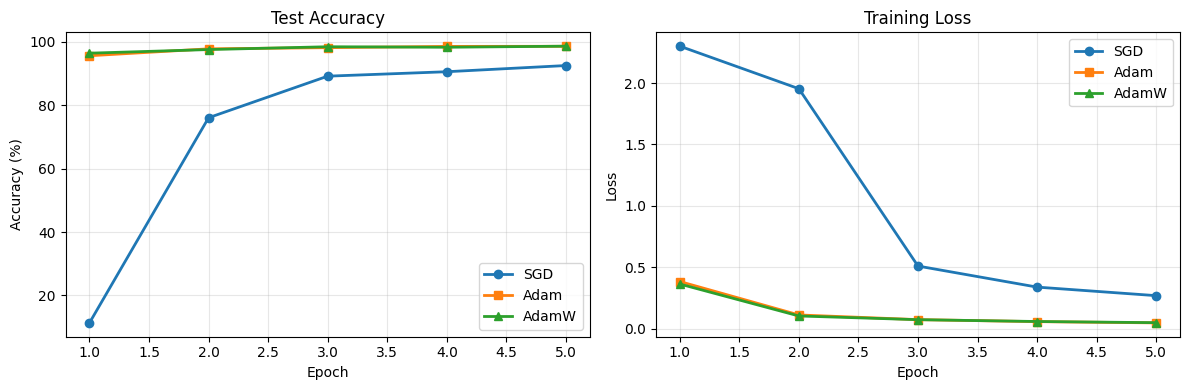

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

# График точности
plt.subplot(1, 2, 1)
plt.plot(range(1, 6), test_accuracies_sgd, label='SGD', marker='o', linewidth=2)
plt.plot(range(1, 6), test_accuracies_adam, label='Adam', marker='s', linewidth=2)
plt.plot(range(1, 6), test_accuracies_adamw, label='AdamW', marker='^', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# График потерь
plt.subplot(1, 2, 2)
plt.plot(range(1, 6), train_losses_sgd, label='SGD', marker='o', linewidth=2)
plt.plot(range(1, 6), train_losses_adam, label='Adam', marker='s', linewidth=2)
plt.plot(range(1, 6), train_losses_adamw, label='AdamW', marker='^', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

<b> Задача 2 <b>

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR
import pandas as pd

# Модифицированная функция обучения с шедулером
def train_model_with_scheduler(model, train_loader, test_loader, optimizer, scheduler, num_epochs):
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Валидация
        model.eval()
        correct = 0
        total = 0
        test_loss = 0
        with torch.no_grad():
            for data, target in test_loader:
                output = model(data)
                test_loss += criterion(output, target).item()
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

        # Шаг шедулера после эпохи
        if scheduler:
            scheduler.step()

        avg_train_loss = total_loss / len(train_loader)
        avg_test_loss = test_loss / len(test_loader)
        accuracy = 100 * correct / total

        train_losses.append(avg_train_loss)
        test_accuracies.append(accuracy)

        print(f'Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Test Loss = {avg_test_loss:.4f}, Accuracy = {accuracy:.2f}%')

    return train_losses[-1], test_accuracies[-1]  # возвращаем последние значения

# Результаты
results = []

# 1. Без шедулеров (повторяем для consistency)
optimizers = [
    ('SGD', optim.SGD, {'lr': 0.01}),
    ('Adam', optim.Adam, {'lr': 0.001}),
    ('AdamW', optim.AdamW, {'lr': 0.001, 'weight_decay': 0.01})
]

for opt_name, opt_class, opt_params in optimizers:
    model = LeNet()
    optimizer = opt_class(model.parameters(), **opt_params)

    print(f"\n=== {opt_name} (no scheduler) ===")
    final_loss, final_acc = train_model_with_scheduler(
        model, train_loader, test_loader, optimizer, None, num_epochs=5
    )
    results.append({
        'Method': f'{opt_name} (no scheduler)',
        'Test Loss': f'{final_loss:.4f}',
        'Test Accuracy': f'{final_acc:.4f}'
    })

# 2. С LinearLR
for opt_name, opt_class, opt_params in optimizers:
    model = LeNet()
    optimizer = opt_class(model.parameters(), **opt_params)
    scheduler = LinearLR(optimizer, start_factor=1.0, end_factor=0.1, total_iters=5)

    print(f"\n=== {opt_name} + LinearLR ===")
    final_loss, final_acc = train_model_with_scheduler(
        model, train_loader, test_loader, optimizer, scheduler, num_epochs=5
    )
    results.append({
        'Method': f'{opt_name} + LinearLR',
        'Test Loss': f'{final_loss:.4f}',
        'Test Accuracy': f'{final_acc:.4f}'
    })

# 3. С CosineAnnealingLR
for opt_name, opt_class, opt_params in optimizers:
    model = LeNet()
    optimizer = opt_class(model.parameters(), **opt_params)
    scheduler = CosineAnnealingLR(optimizer, T_max=5, eta_min=0)

    print(f"\n=== {opt_name} + Cosine ===")
    final_loss, final_acc = train_model_with_scheduler(
        model, train_loader, test_loader, optimizer, scheduler, num_epochs=5
    )
    results.append({
        'Method': f'{opt_name} + Cosine',
        'Test Loss': f'{final_loss:.4f}',
        'Test Accuracy': f'{final_acc:.4f}'
    })

# Создаем таблицу результатов
df_results = pd.DataFrame(results)
print("\n" + "="*50)
print("СРАВНИТЕЛЬНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ")
print("="*50)
print(df_results.to_string(index=False))


=== SGD (no scheduler) ===
Epoch 1: Train Loss = 2.2901, Test Loss = 2.2541, Accuracy = 38.59%
Epoch 2: Train Loss = 1.1848, Test Loss = 0.4541, Accuracy = 85.99%
Epoch 3: Train Loss = 0.4087, Test Loss = 0.3124, Accuracy = 90.48%
Epoch 4: Train Loss = 0.3039, Test Loss = 0.2380, Accuracy = 92.88%
Epoch 5: Train Loss = 0.2482, Test Loss = 0.2653, Accuracy = 91.60%

=== Adam (no scheduler) ===
Epoch 1: Train Loss = 0.3650, Test Loss = 0.1225, Accuracy = 96.03%
Epoch 2: Train Loss = 0.1108, Test Loss = 0.0863, Accuracy = 97.22%
Epoch 3: Train Loss = 0.0784, Test Loss = 0.0544, Accuracy = 98.28%
Epoch 4: Train Loss = 0.0609, Test Loss = 0.0481, Accuracy = 98.40%
Epoch 5: Train Loss = 0.0496, Test Loss = 0.0502, Accuracy = 98.43%

=== AdamW (no scheduler) ===
Epoch 1: Train Loss = 0.3630, Test Loss = 0.1334, Accuracy = 95.58%
Epoch 2: Train Loss = 0.1070, Test Loss = 0.0747, Accuracy = 97.63%
Epoch 3: Train Loss = 0.0760, Test Loss = 0.0562, Accuracy = 98.16%
Epoch 4: Train Loss = 0.0602,

Выводы по шедулерам : лучший скор показали Adam + LinearLR , AdamW + LinearLR . Для SGD шедуляры не сработали.